# Vision par ordinateur avec des Transformers


Dans ce notebook, nous utilisons la bibliothèque Transformers de Hugging Face pour traiter des images. Pour éviter de surcharger le notebook, certaines fonctions se trouvent dans utils/util.py.


## Détection d'objets sans apprentissage (Zero-Shot)


La détection d'objets dans une image est une tâche clé en vision par ordinateur. Les modèles zero-shot sont super pratiques car ils détectent n'importe quel objet sans besoin de fine-tuning. Il suffit de leur donner une image et un prompt textuel avec les classes à détecter.


### Mise en œuvre


On a opté pour le modèle OWL-ViT de Google (google/owlvit-base-patch32) car il est compact et fonctionne sur la plupart des machines. Utilisons le pipeline de Hugging Face :


In [1]:
from transformers import pipeline
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

zeroshot = pipeline("zero-shot-object-detection", model="google/owlvit-base-patch32")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Jetons un coup d'œil à notre image.


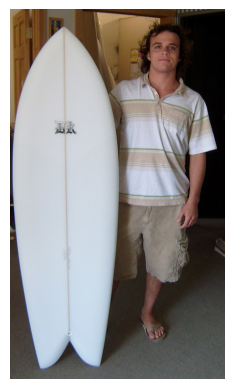

In [119]:
image=Image.open("images/coco.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

Utilisons le modèle pour dessiner les boîtes de détection prédites.


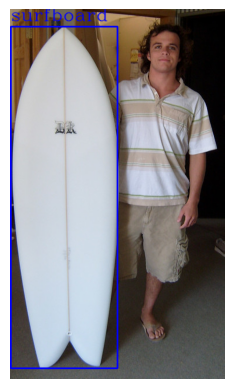

In [120]:
from utils.util import draw_box

text_prompt = "surfboard" # Vous pouvez changer la classe pour détecter autre chose "person" ou "surfboard"
output = zeroshot(image,candidate_labels = [text_prompt])
cv_image=draw_box(image,output)

plt.imshow(cv_image)
plt.axis('off') 
plt.show()

Vous savez maintenant comment implémenter un détecteur d'objets zero-shot en quelques lignes de code.


## Génération de légendes pour images


L'image captionning consiste à générer une description pour une image. Le modèle prend une image en entrée et produit une légende.


### Mise en œuvre


Comme précédemment, on utilise le pipeline de Hugging Face. Ici, on utilise le modèle BLIP de Salesforce (Salesforce/blip-image-captioning-base).


In [121]:
captionner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")

On utilise la même image pour générer une description.


In [122]:
result=captionner(image)
print(result[0]['generated_text'])

a man holding a surfboard in a room


On a généré la description "un homme qui tient une planche de surf dans une pièce", ce qui est exact.
Vous savez maintenant générer des descriptions d'images. C'est super utile pour créer automatiquement des datasets par exemple.


## Classification d'images sans apprentissage (Zero-Shot)


En plus de la détection d'objets zero-shot, on peut faire de la classification d'images zero-shot. Le principe est similaire, mais cette fois on donne au moins deux phrases et le modèle nous donne la probabilité que l'image corresponde à l'une ou l'autre.


### Mise en œuvre


Utilisons une photo de mon chat pour déterminer sa race :


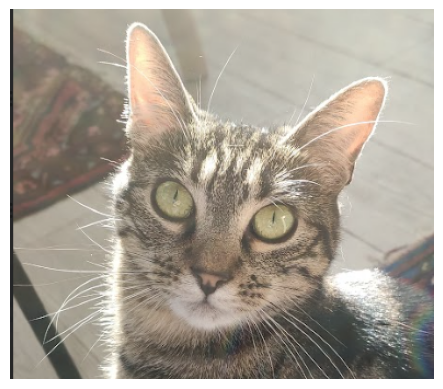

In [123]:
image=Image.open("images/tigrou.png") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

On va voir si le modèle peut déterminer s'il s'agit d'un Maine Coon ou d'un chat européen.


On utilise le modèle CLIP d'OpenAI (openai/clip-vit-base-patch32). Pour varier, on utilise d'autres fonctions de la bibliothèque Hugging Face au lieu du pipeline.


In [125]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-base-patch32")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [133]:
labels = ["a photo of a european shorthair", "a photo of maine coon"]
inputs = processor(text=labels,images=image,return_tensors="pt",padding=True)
outputs = model(**inputs)

# Transformation des outputs pour obtenir des probabilités
print("Probabilité de a photo of a european shorthair : ",outputs.logits_per_image.softmax(dim=1)[0][0].item())
print("Probabilité de a photo of maine coon : ",outputs.logits_per_image.softmax(dim=1)[0][1].item())

Probabilité de a photo of a european shorthair :  0.9104425311088562
Probabilité de a photo of maine coon :  0.08955750614404678


Le modèle est plutôt sûr qu'il s'agit d'un chat européen, et effectivement, il a raison.


## Segmentation d'images


Pour cet exemple, on utilise le modèle SAM de Meta qui permet de segmenter n'importe quel objet.


### Mise en œuvre


In [2]:
sam = pipeline("mask-generation","Zigeng/SlimSAM-uniform-77")

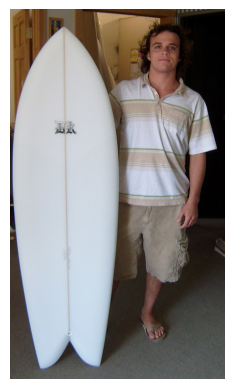

In [3]:
image=Image.open("images/coco.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

In [8]:
# ATTENTION : le traitement peut prendre plusieurs minutes
output=sam(image, points_per_batch=32)

In [5]:
masks=output["masks"]

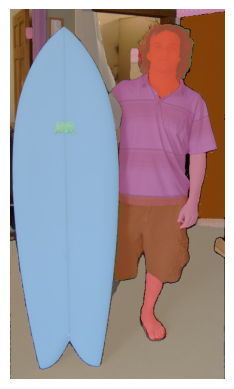

In [7]:
from utils.util import draw_masks
image_np=draw_masks(image,masks)

plt.imshow(image_np)
plt.axis('off') 
plt.show()

Comme vous pouvez le voir, on a segmenté tous les objets de l'image. Par contre, le temps de traitement était assez long...
Pour un temps d'inférence plus raisonnable, on utilise un prompt de coordonnées d'un point de l'image. Cela permet de spécifier le traitement et d'obtenir un résultat plus rapidement.
On ne peut pas utiliser le pipeline pour cette tâche.


In [9]:
from transformers import SamModel, SamProcessor

In [10]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

Créons notre prompt de coordonnées et visualisons le point :


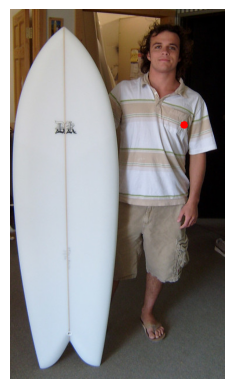

In [41]:
input_points = [[[300, 200]]]
image_np= np.array(image)
cv2.circle(image_np,input_points[0][0],radius=3,color=(255,0,0),thickness=5)
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [44]:
inputs = processor(image,input_points=input_points,return_tensors="pt")
outputs = model(**inputs)
predicted_masks = processor.image_processor.post_process_masks(
  outputs.pred_masks,
  inputs["original_sizes"],
  inputs["reshaped_input_sizes"]
)

Le traitement est bien plus rapide !
SAM produit 3 masques par défaut. Chaque masque représente une possibilité de segmentation de l'image. Vous pouvez changer la valeur **mask_number** pour visualiser les différents masques.


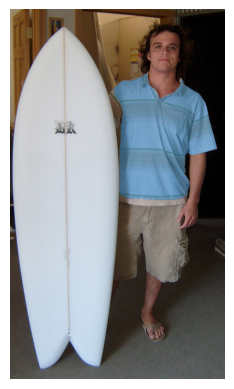

In [46]:
mask_number=2 # 0,1 or 2
mask=predicted_masks[0][:, mask_number] 
image_np=draw_masks(image,mask)
plt.imshow(image_np)
plt.axis('off') 
plt.show()

Dans cet exemple, on voit que les 3 masques sont pertinents : le premier segmente la personne entière, le second segmente les vêtements et le troisième segmente uniquement le t-shirt.
Vous pouvez essayer de changer les coordonnées du point et de visualiser les masques générés.


## Estimation de la profondeur


L'estimation de la profondeur est une tâche clé en vision par ordinateur. C'est super utile pour des applications comme les voitures autonomes où on estime la distance par rapport au véhicule devant nous. Pour l'industrie, c'est aussi intéressant pour organiser les objets dans un colis en fonction de l'espace restant.
Pour cet exemple, on utilise le modèle DPT (Intel/dpt-hybrid-midas) qui prend une image en entrée et renvoie une carte de profondeur.


### Mise en œuvre


In [47]:
depth_estimator = pipeline(task="depth-estimation",model="Intel/dpt-hybrid-midas")

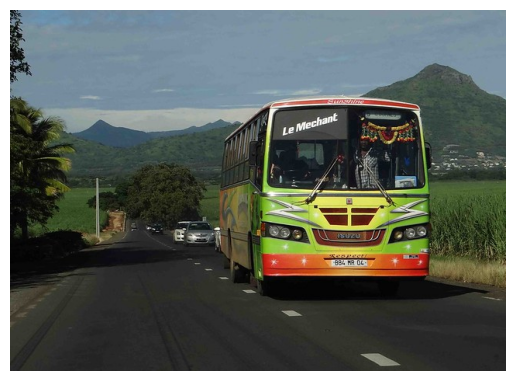

In [48]:
image=Image.open("images/coco2.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

In [57]:
outputs = depth_estimator(image)
outputs["predicted_depth"].shape

torch.Size([1, 384, 384])

On utilise PyTorch pour adapter la dimension de la carte de profondeur prédite à celle de notre image de base, puis on génère une image de la carte de profondeur.


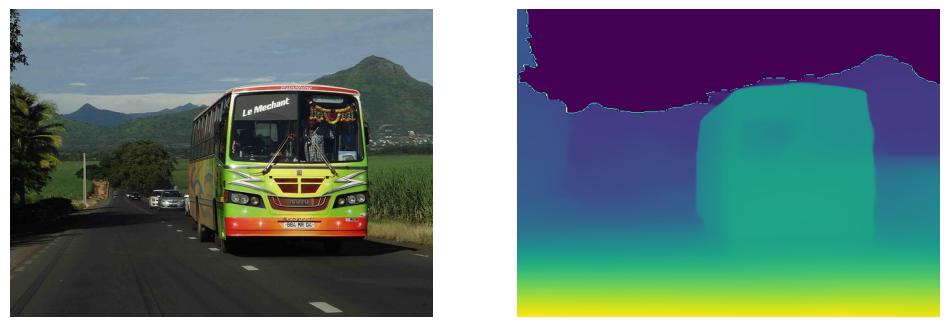

In [60]:
import torch 
prediction = torch.nn.functional.interpolate(outputs["predicted_depth"].unsqueeze(1),size=image.size[::-1],
                                             mode="bicubic",align_corners=False)
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 
ax1.imshow(image)
ax1.axis('off')  
ax2.imshow(depth)
ax2.axis('off')  
plt.show()

Sur la carte de profondeur, les couleurs vives représentent les objets les plus proches. On voit bien la route proche en couleur très vive et le bus en couleur assez vive. La carte de profondeur est donc précise.
